In [58]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from keras.metrics import Precision, Recall

import warnings
warnings.filterwarnings("ignore")


In [59]:
# Собор пути к файлам и меток классов из структуры директорий, где каждая поддиректория является отдельным классом

data_dir = './dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries =pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
df

,filepaths,labels
0,./dataset/rime/5294.jpg,rime
1,./dataset/rime/5431.jpg,rime
2,./dataset/rime/5892.jpg,rime
3,./dataset/rime/5809.jpg:Zone.Identifier,rime
4,./dataset/rime/5558.jpg,rime
...,...,...
13719,./dataset/snow/1163.jpg:Zone.Identifier,snow
13720,./dataset/snow/1032.jpg:Zone.Identifier,snow
13721,./dataset/snow/1208.jpg,snow
13722,./dataset/snow/0957.jpg:Zone.Identifier,snow


In [70]:
# Разделение исходного DataFrame на обучающий и валидационный наборы данных
train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

# Определение параметров для генераторов данных
batch_size = 64  # Размер пакета данных используемого при обучении
img_size = (128, 128)  # Размер изображения
channels = 3  # Количество каналов (в данном случае, RGB)
img_shape = (img_size[0], img_size[1], channels)  # Форма изображения

# Определение функции для масштабирования изображений (в данном случае, она остается без изменений (изображение просто возвращается, чтобы потом изменить его размер))
def scalar(img):
    return img

# Создание генератора данных для обучающего набора
tr_gen = ImageDataGenerator(preprocessing_function=scalar)
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# Создание генератора данных для валидационного набора
ts_gen = ImageDataGenerator(preprocessing_function=scalar)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


Found 5498 validated image filenames belonging to 11 classes.
Found 1364 validated image filenames belonging to 11 classes.


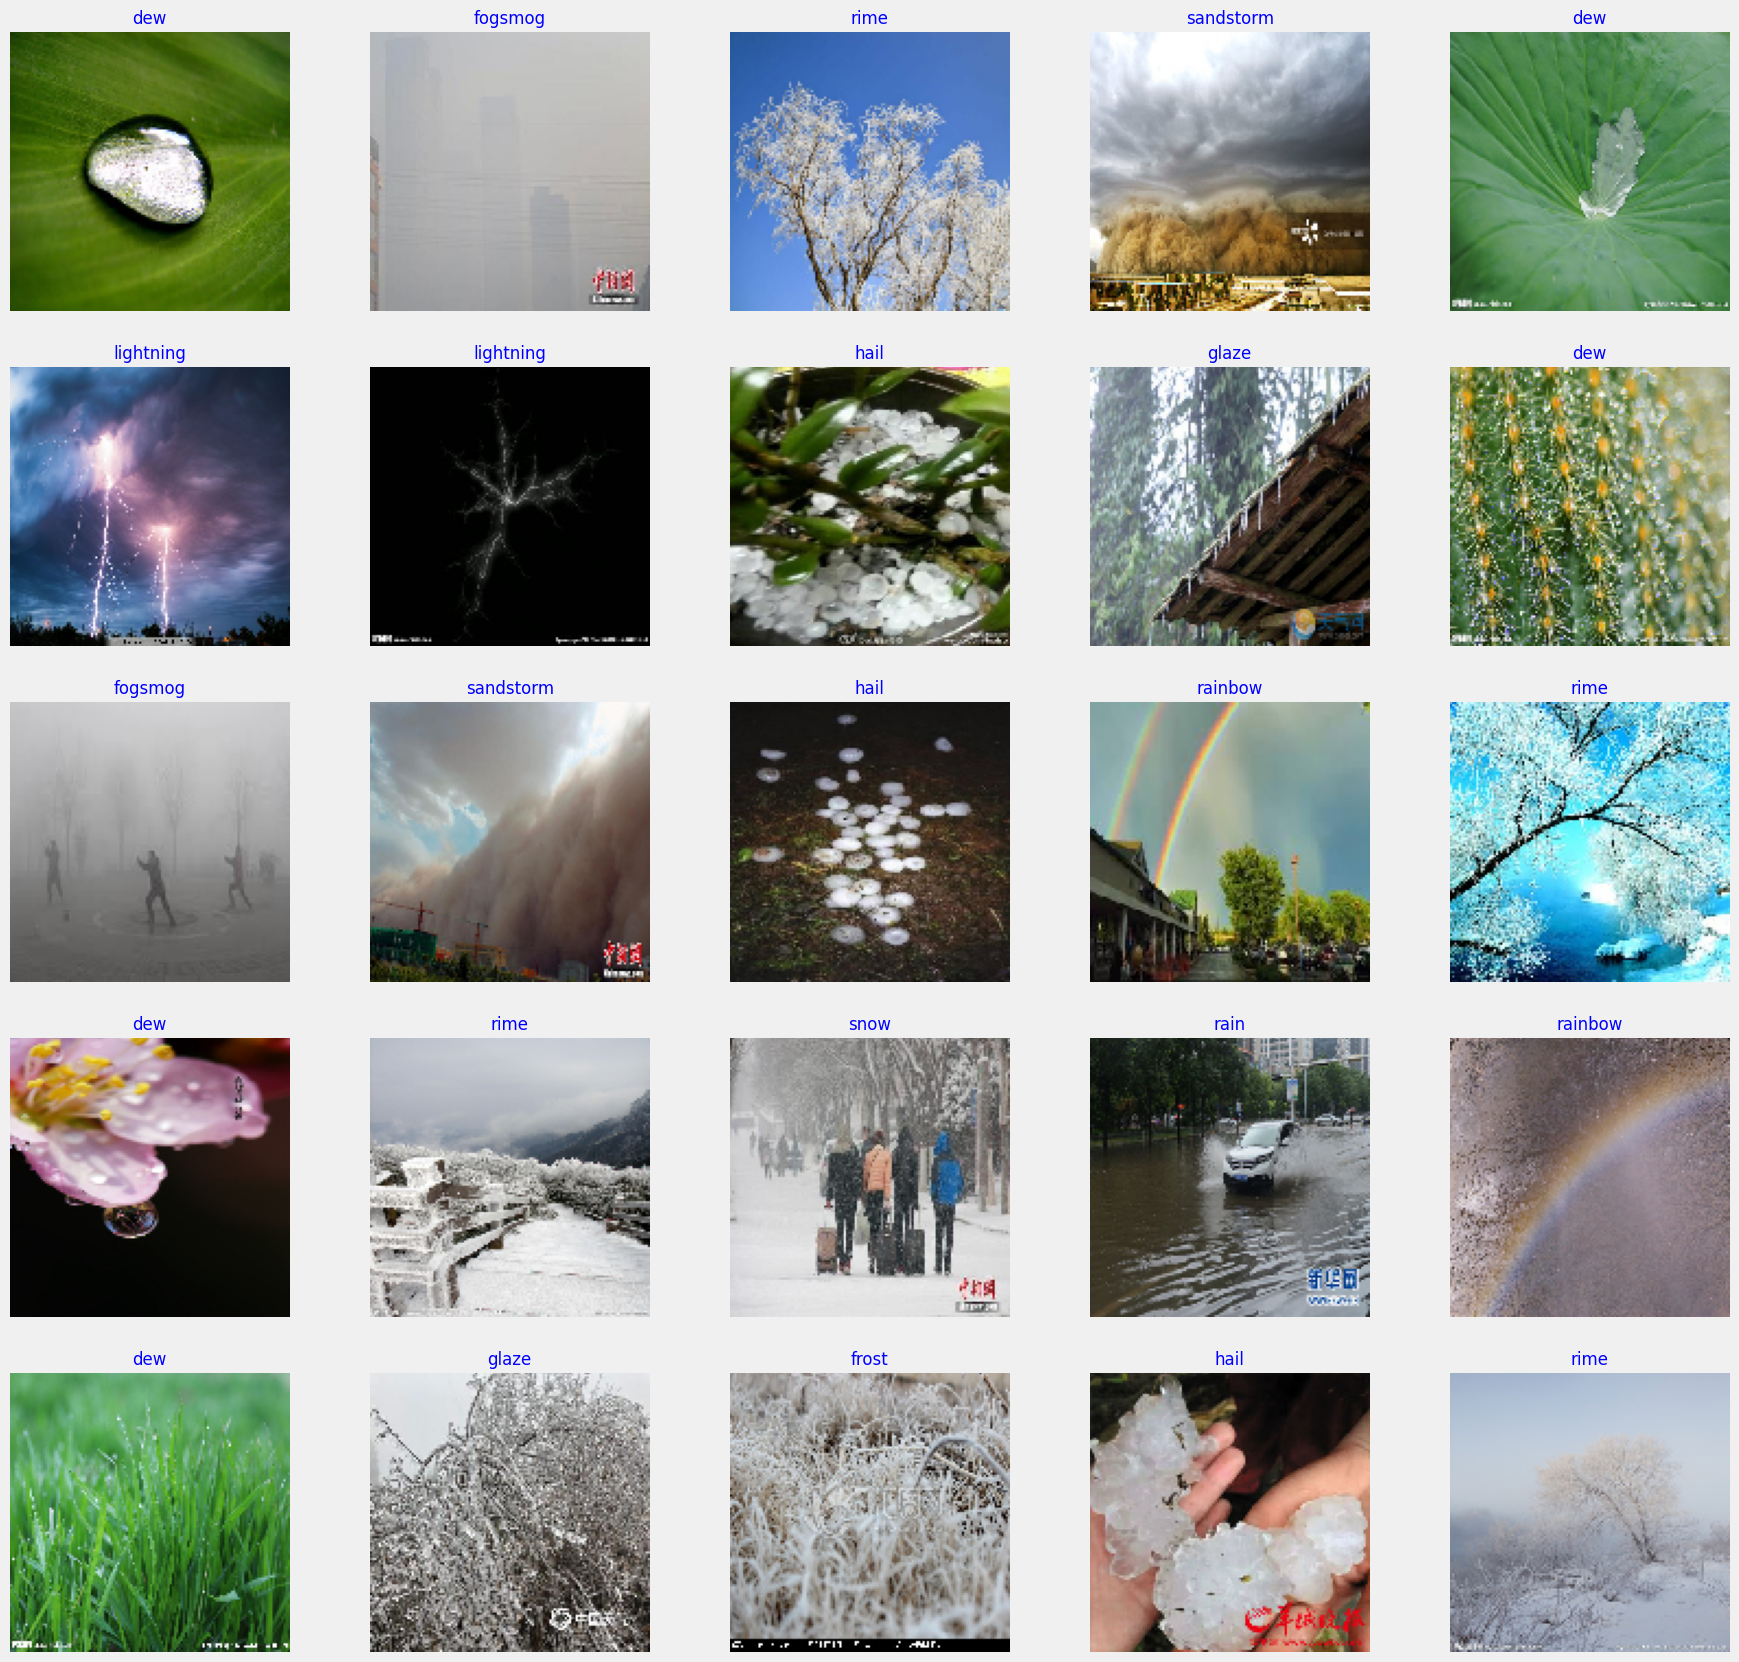

In [62]:
# Визуализация изображений используемого датасета
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

length = len(labels)
sample = min(length, 25)

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [63]:
# Задание размера изображения
img_size = (128, 128)
# Задание количества цветовых каналов (RGB)
channels = 3
# Формирование формы изображения
img_shape = (img_size[0], img_size[1], channels)
# Получение количества классов (категорий) из обучающего генератора (для задания значени на выходном слое)
class_count = len(list(train_gen.class_indices.keys()))
# Оптимизатор
optimizer_ = Adamax(learning_rate=0.001)
# optimizer_ = tf.keras.optimizers.SGD(learning_rate=0.01)
# optimizer_ = tf.keras.optimizers.Adam(learning_rate=0.001)
# optimizer_ = tf.keras.optimizers.Nadam(learning_rate=0.001)
# optimizer_ = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# Функция потерь
loss_ = 'categorical_crossentropy'

# Загрузка модели EfficientNetB3 из библиотеки Keras
base_model = keras.applications.efficientnet.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)

# Создание последовательной модели
model = Sequential([
    # Добавление предварительно обученной модели в качестве базовой модели
    base_model, 
    # Слой для улучшения производительность и обучаемости модели
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    # Полносвязный слой (регуляризаторы используются для предотвроащения переобучения модели)
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    # Слой Dropout для регуляризации и предотвращения переобучения
    Dropout(rate=0.45, seed=123), 
    # Выходной слой по количеству классов
    Dense(class_count, activation='softmax')
])

# Компиляция модели и вывод ее параметров
model.compile(optimizer=optimizer_, loss=loss_, metrics=[Precision(), Recall(), 'accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_5 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 256)               393472    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 11)                2827      
                                                                 
Total params: 11185978 (42.67 MB)
Trainable params: 11

In [64]:
# Количество эпох
epochs = 10  

# Обучение модели
history = model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen, 
                    validation_steps=None, shuffle=False)

Epoch 1/10


2023-12-08 16:10:16.120612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


86/86 [==============================] - 61s 328ms/step - loss: 7.8164 - precision_5: 0.7981 - recall_5: 0.5926 - accuracy: 0.6801 - val_loss: 6.4284 - val_precision_5: 0.8772 - val_recall_5: 0.7647 - val_accuracy: 0.8240
Epoch 2/10
86/86 [==============================] - 26s 292ms/step - loss: 5.3612 - precision_5: 0.9372 - recall_5: 0.8067 - accuracy: 0.8800 - val_loss: 4.6771 - val_precision_5: 0.9158 - val_recall_5: 0.8292 - val_accuracy: 0.8790
Epoch 3/10
86/86 [==============================] - 26s 295ms/step - loss: 3.9277 - precision_5: 0.9666 - recall_5: 0.8898 - accuracy: 0.9374 - val_loss: 3.5181 - val_precision_5: 0.9255 - val_recall_5: 0.8475 - val_accuracy: 0.8827
Epoch 4/10
86/86 [==============================] - 26s 297ms/step - loss: 2.8906 - precision_5: 0.9815 - recall_5: 0.9289 - accuracy: 0.9625 - val_loss: 2.6705 - val_precision_5: 0.9221 - val_recall_5: 0.8504 - val_accuracy: 0.8871
Epoch 5/10
86/86 [==============================] - 26s 296ms/step - loss: 2.13

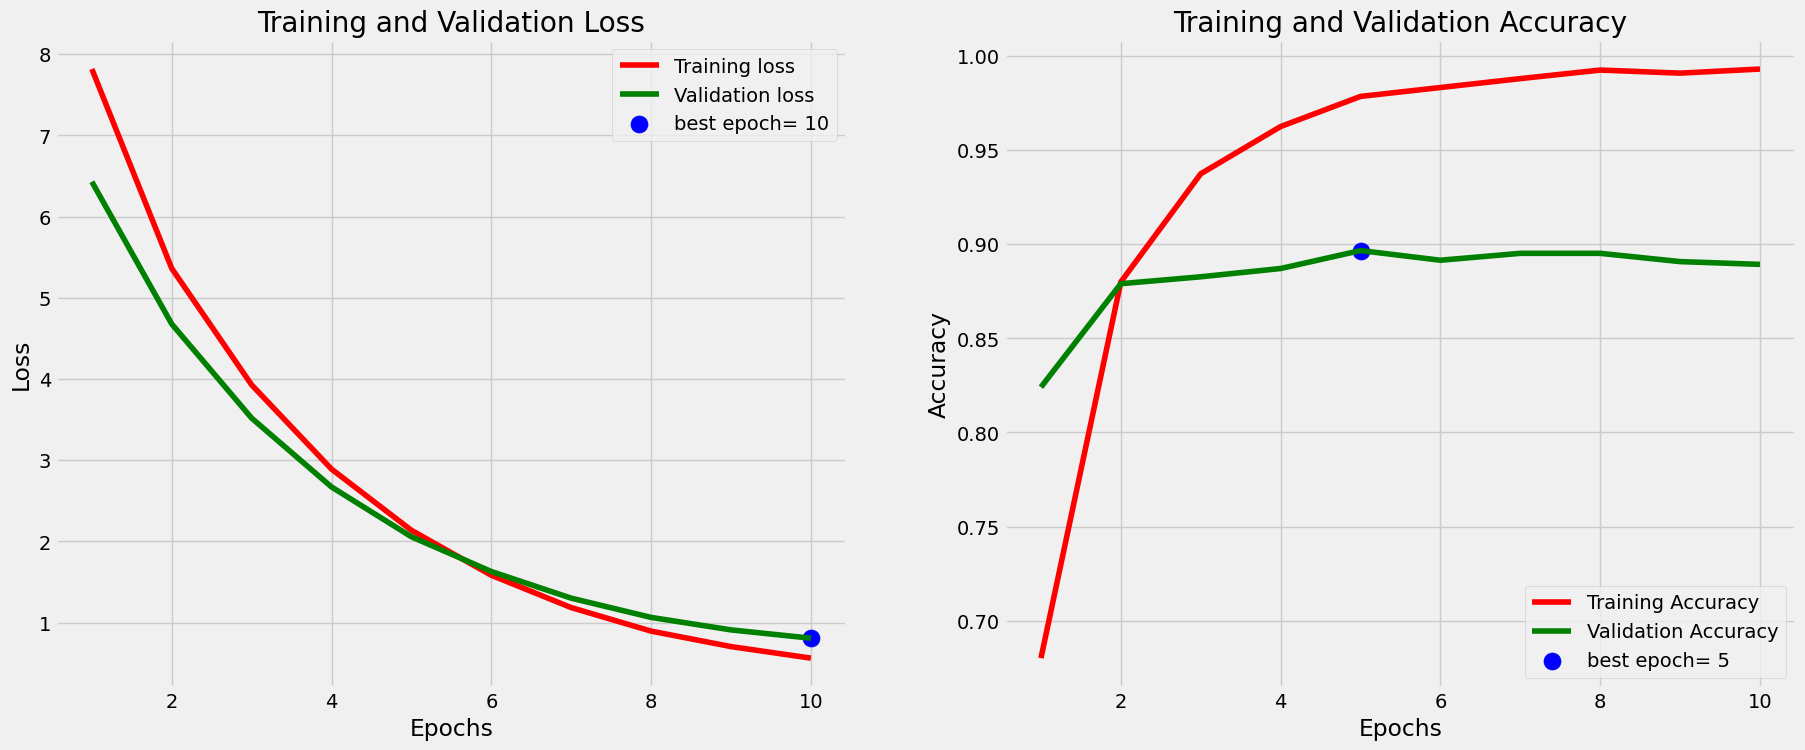

In [65]:
# Графики потерь и точности модели
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [66]:
# Сохраненние модели
model.save('model.h5')

In [67]:
# Загрузка сохранненной модели
loaded_model = keras.models.load_model('./model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics= ['accuracy'])

In [68]:
# Путь к изображению для проверки обученной модели
image_path = './test_predict/test_picture.jpg'
image = Image.open(image_path)

# Предобработка изображения
img = image.resize((128, 128))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Классификация загруженного изображения
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(class_labels[tf.argmax(score)])

1/1 [==============================] - 2s 2s/step
rime
